<h1>Covid Data Prep</h1>
<h3>Feature Engineering</h3>
<p>The notebook below takes the Covid-19 df and prepares it to use in Deep Learning Notebooks</p>
<br>
<p>The raw data consists of the following feature</p>
<ol>
    <li>dateRep</li>
    <li style="color:red;">day</li>
    <li style="color:red;">month</li>
    <li style="color:red;">year</li>
    <li>cases</li>
    <li>deaths</li>
    <li>countriesAndTerritories</li>
    <li style="color:red;">geoId</li>
    <li style="color:red;">countryterritorycode</li>
    <li>popData2018</li>
    <li>continentExp</li>
</ol>
<br>
</p>Feature names in red will be remove as they were defined as adding little information to the model. The remaining feautures will be evaluated through the notebook below.</p>

<h5>Import dependancies</h5>
<ul>
    <li>pandas: feature extrapolation and extraction and creation</li>
    <li>numpy: numerical data manipluation</li>
    <li>os: interaction with the operating system</li>
    <li>seaborn: plotting library</li>
    <li>sklearn.model_selection.train_test_split: spliting the data into the various data sets (train, test and validation)</li>
</ul>

In [304]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

</h2>Read in raw data</h2>

<p>Change to the relevant directory and read in the csv</p>

The csv will need some preprocessing

In [2]:
data_folder = os.path.join(os.getcwd(), 'Datasets')

<p>Now read the file. No Line should need skipping.</p>

In [283]:
# Import and format dataframe
covid19_df = pd.read_csv(os.path.join(data_folder, 'COVID-19_Cases_Worldwide_2020_08_21'), engine='python')
covid19_df.head(2)

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2019,continentExp,Cumulative_number_for_14_days_of_COVID-19_cases_per_100000
0,20/08/2020,20,8,2020,160,8,Afghanistan,AF,AFG,38041757.0,Asia,2.268560
1,19/08/2020,19,8,2020,0,0,Afghanistan,AF,AFG,38041757.0,Asia,2.024092


In [284]:
# Columns to drop
drop_columns = ['geoId', 'day', 'month', 'year', 'countryterritoryCode']
# Create a 'datetime' column based on the dates
covid19_df['dateRep'] = pd.to_datetime(covid19_df['dateRep'], dayfirst=True)
# Drop the columns that add no value
covid19_df.drop(columns=drop_columns, inplace=True)

In [285]:
# Sort the table by the date
covid19_df.sort_values(by=['dateRep'], ascending=True, inplace=True)
# Create a cumulative sum of covid cases and deaths
covid19_df['Cum_Cases'] = covid19_df.groupby("countriesAndTerritories")['cases'].cumsum()
covid19_df['Cum_Deaths'] = covid19_df.groupby("countriesAndTerritories")['deaths'].cumsum()

In [286]:
# Create column for days since x deaths
covid19_df['flag'] = np.where(covid19_df['Cum_Cases'] > 100, 1, 0) # calculate globaly as its a true false
# groupby again creating a unique dataframe for each country, and applying a cumulative sum to the "flag" column
covid19_df['flag'] = covid19_df.loc[covid19_df['Cum_Cases'] > 100].groupby("countriesAndTerritories")['flag'].cumsum()

<p>We don't want Nan's so we replace them in the next few cells below</p>

In [287]:
"""for i in covid19_df.columns:
    frac_null = covid19_df[i].isna().sum() /len(covid19_df)
    print(i, ':', frac_null)"""

"for i in covid19_df.columns:\n    frac_null = covid19_df[i].isna().sum() /len(covid19_df)\n    print(i, ':', frac_null)"

In [288]:
top_count = covid19_df.groupby('countriesAndTerritories')['deaths'].sum().sort_values(ascending=False).iloc[:20]
top_count = list(top_count.keys())
print(top_count)

['United_States_of_America', 'Brazil', 'Mexico', 'India', 'United_Kingdom', 'Italy', 'France', 'Spain', 'Peru', 'Iran', 'Russia', 'Colombia', 'South_Africa', 'Chile', 'Belgium', 'Germany', 'Canada', 'Indonesia', 'Pakistan', 'Netherlands']


In [289]:
# Trim the dataframe to just the 20 most affected countries
covid19_df = covid19_df[covid19_df['countriesAndTerritories'].isin(top_count)]
# Fill the empty 'flag' rows
covid19_df.fillna(0, inplace=True)

In [290]:
# Load in Apple mobility data
mobility_df = pd.read_csv(os.path.join(data_folder, 'Apple_Mobility' , 'applemobilitytrends-2020-08-19.csv'), engine='python')
# Only select the overall country data 'country/region' and drop columns not needed
mobility_df = mobility_df.loc[mobility_df['geo_type'] == 'country/region'].drop(columns=['sub-region', 'country', 'alternative_name', 'geo_type'])

In [291]:
# 'melt' the dataframe so that dates are listed by row and not column
mobility_df = mobility_df.melt(id_vars=['transportation_type', 'region'])
# Format the strings so the countries match e.g. remove space and add in underscore.
mobility_df = mobility_df.replace({'region': {'United States': 'United_States_of_America', 'Republic of Korea': 'South_Korea', ' ': '_'}}, regex=True)
# Create a 'datetime' column
mobility_df['variable'] = pd.to_datetime(mobility_df['variable'], dayfirst=True)

In [292]:
# pivot the table to split out the transportation types.
mobility_df = pd.pivot_table(mobility_df, values='value', index=['region', 'variable'], columns=['transportation_type'], aggfunc=np.max).reset_index()

In [293]:
# Merge the mobility data into the covid_df
covid19_df = covid19_df.merge(mobility_df, left_on=['countriesAndTerritories', 'dateRep'], right_on=['region', 'variable']).drop(columns=['variable', 'region'])

In [300]:
top_count1 = covid19_df.groupby('countriesAndTerritories')['deaths'].sum().sort_values(ascending=False).iloc[:20]
top_count1 = list(top_count1.keys())
set(top_count).difference(top_count1)

{'Iran', 'Pakistan', 'Peru'}

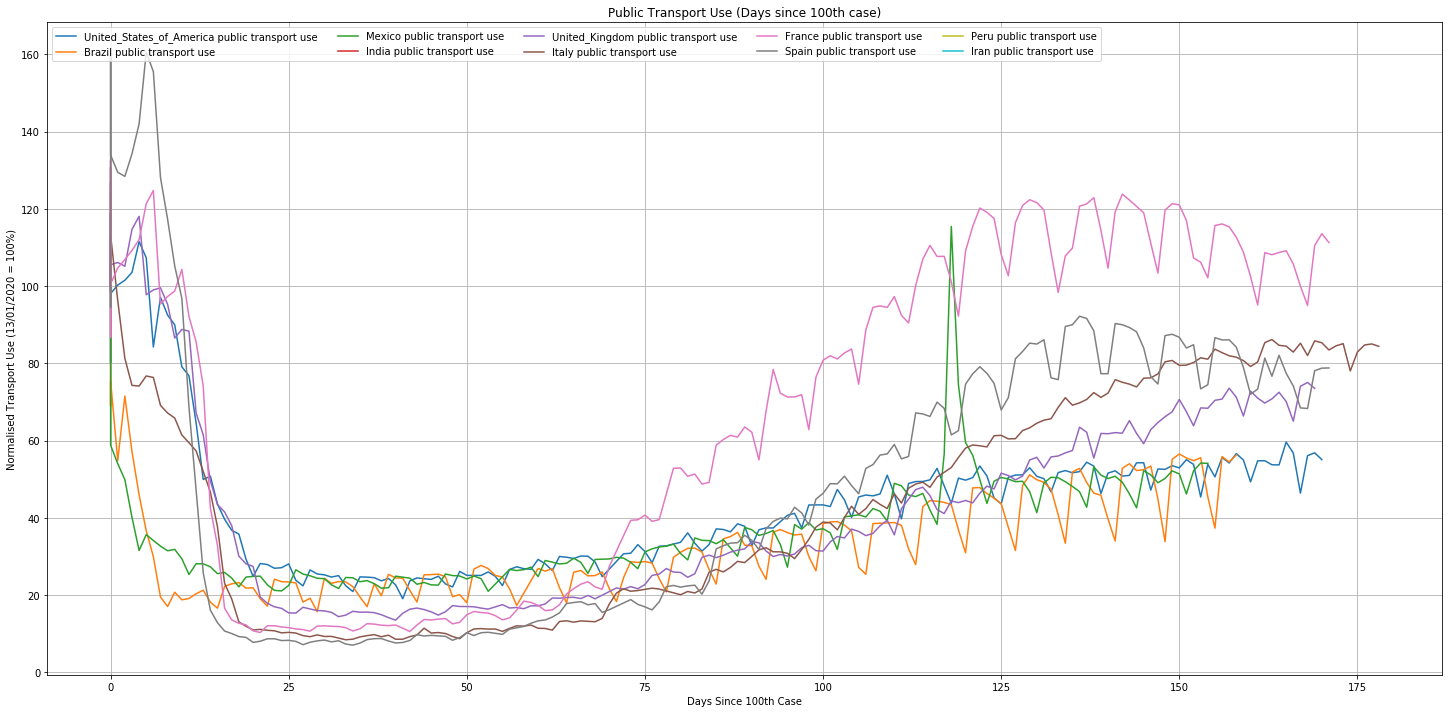

In [301]:
# Visualising the transport use over time by the first 10 countries
plt.figure(figsize=(25, 12))
for country in top_count[:10]:
    plt.plot(covid_df[covid_df["countriesAndTerritories"] == country]["flag"],
             covid_df[covid_df["countriesAndTerritories"] == country]["transit"], label=f"{country} public transport use")
plt.title('Public Transport Use (Days since 100th case)')
plt.xlabel('Days Since 100th Case')
plt.ylabel('Normalised Transport Use (13/01/2020 = 100%)')
plt.grid()
plt.legend(ncol=5, loc=2)
plt.show()

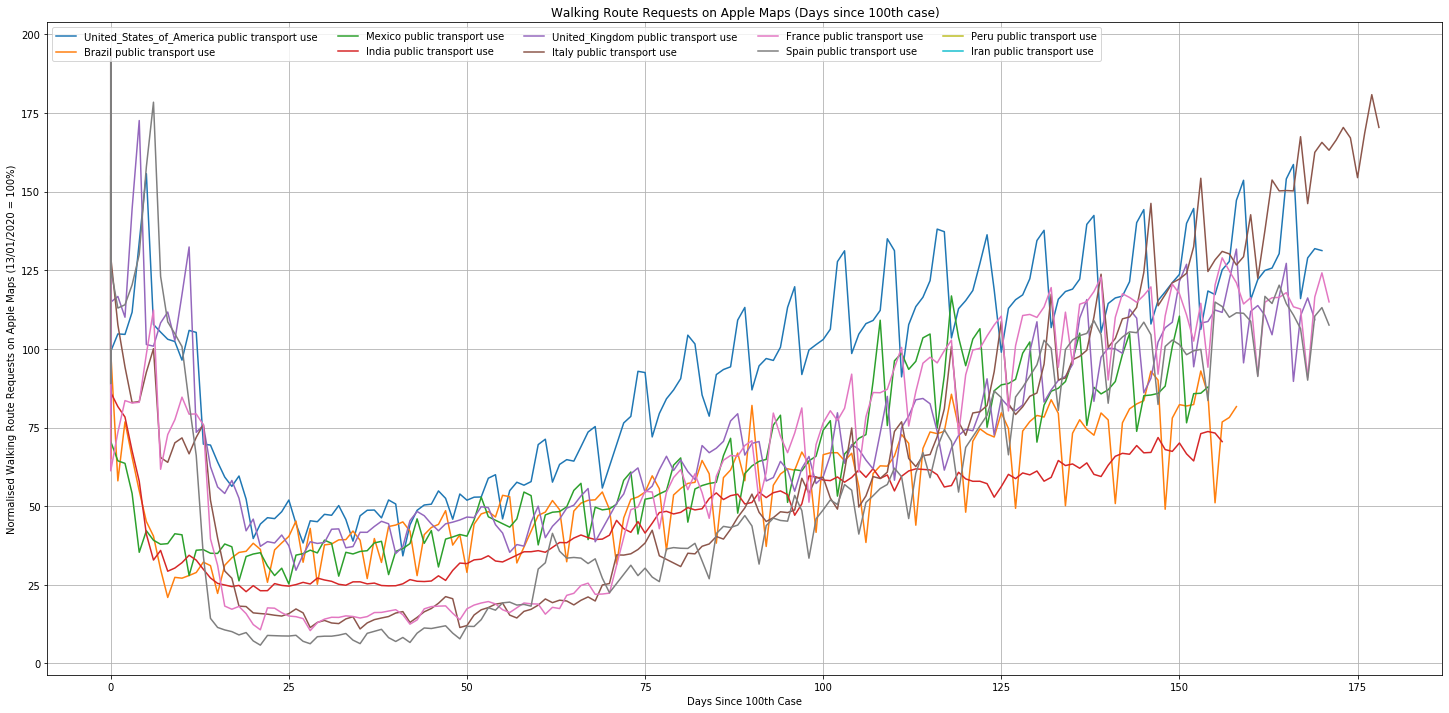

In [303]:
# Visualising the walking requests through apple maps over time (first 10 countries)
plt.figure(figsize=(25, 12))
for country in top_count[:10]:
    plt.plot(covid_df[covid_df["countriesAndTerritories"] == country]["flag"],
             covid_df[covid_df["countriesAndTerritories"] == country]["walking"], label=f"{country} public transport use")
plt.title('Walking Route Requests on Apple Maps (Days since 100th case)')
plt.xlabel('Days Since 100th Case')
plt.ylabel('Normalised Walking Route Requests on Apple Maps (13/01/2020 = 100%)')
plt.grid()
plt.legend(ncol=5, loc=2)
plt.show()

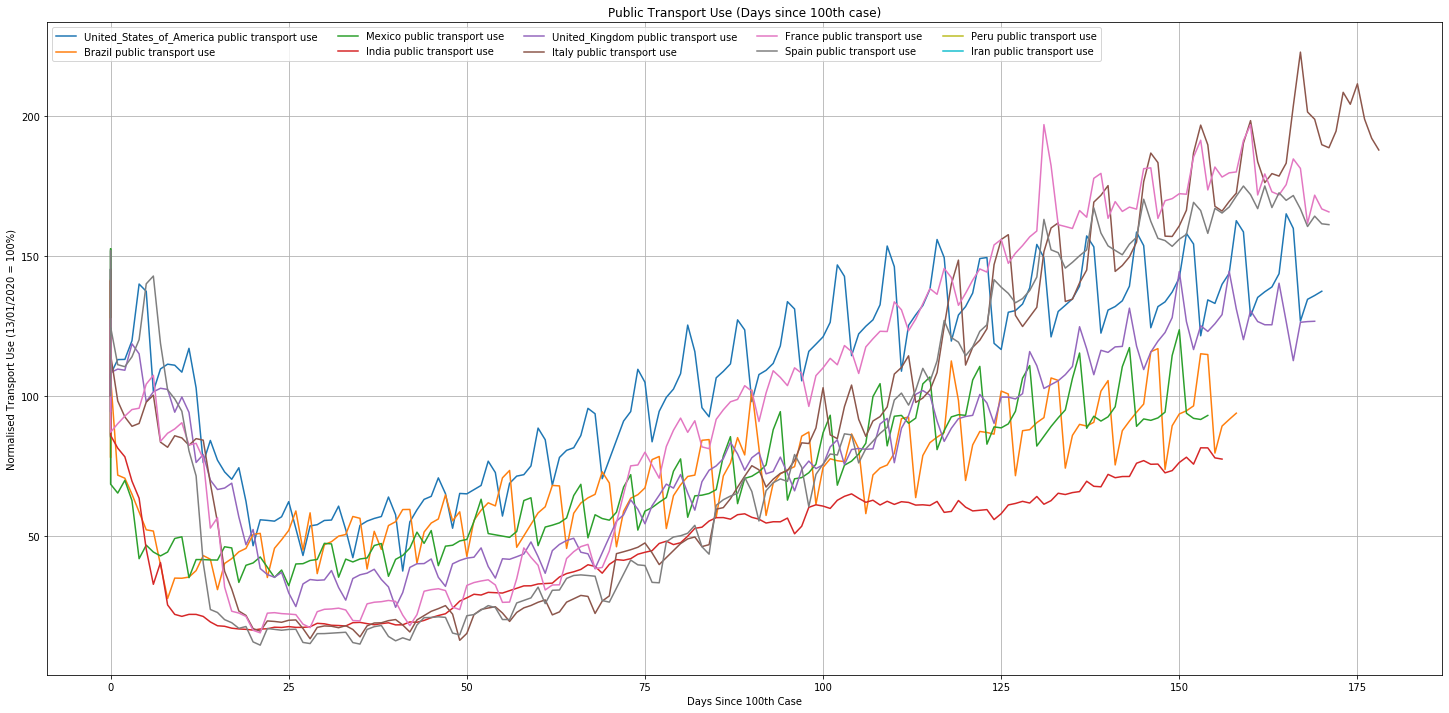

In [261]:
# Visualising the transport use over time by country
plt.figure(figsize=(25, 12))
for country in top_count[:10]:
    plt.plot(covid_df[covid_df["countriesAndTerritories"] == country]["flag"],
             covid_df[covid_df["countriesAndTerritories"] == country]["driving"], label=f"{country} public transport use")
plt.title('Relative Driving Requests (Days since 100th case)')
plt.xlabel('Days Since 100th Case')
plt.ylabel('Normalised Transport Use (13/01/2020 = 100%)')
plt.grid()
plt.legend(ncol=5, loc=2)
plt.show()

In [315]:
path_list = []
corp_list = []
house_list = []
google_df = pd.DataFrame()
for root, dirs, files in os.walk(os.path.join(data_folder, 'Google_Search')):

    for file in files:
            if file.endswith(".csv"):
                pname = os.path.join(root, file)
                col_name = pname.split('/')[-1]
                col_name = col_name.rpartition('_')[0]
                print(col_name)
                country_name = pname.split('/')[-2]
                print(country_name)
                col_name = col_name.split('.')[0]

                
                """if corp in col_name:
                    corp_list.append(col_name)
                if house in col_name:
                    house_list.append(col_name)"""


                blank_df = pd.read_csv(pname, names=['date', col_name], skiprows=1)
                # Datetime at the index
                blank_df.index = pd.to_datetime(blank_df['date'])
                # Drop the old 'date' column
                blank_df.drop(columns='date', inplace=True)


                # Fullstop value on nulls needs removing
                blank_df = blank_df[blank_df[col_name] != '.']
                # Convert the gold column to float (fullstops prevented this)
                blank_df[col_name] = pd.to_numeric(blank_df[col_name])
                # Resample on the month
                blank_df = blank_df.resample("M").mean()
                # Interpolate NaN's
                blank_df = blank_df.interpolate(method='polynomial', order=2)


                if len(path_list) < 2:
                    gold_df = blank_df
                    
                else:
                    gold_df = gold_df.merge(blank_df, how='outer', left_index=True, right_index=True)




DIY
Global_Total
Cafe
Global_Total
online_lesson
Global_Total
Bar
Global_Total
Home_Workout
Global_Total
Sewing
Global_Total
Restaurant
Global_Total
DIY
France
Cafe
France
online_lesson
France
Bar
France
Home_Workout
France
Sewing
France
Restaurant
France
DIY
Germany
Cafe
Germany
online_lesson
Germany
Bar
Germany
Home_Workout
Germany
Sewing
Germany
Restaurant
Germany
DIY
Italy
Cafe
Italy
online_lesson
Italy
Bar
Italy
Home_workout
Italy
Sewing
Italy
Restaurant
Italy
DIY
United_Kingdom
Bar_Search
United_Kingdom
Cafe
United_Kingdom
online_lesson
United_Kingdom
Home_Workout
United_Kingdom
Sewing
United_Kingdom
Restaurant
United_Kingdom


In [307]:
UK_rest = pd.read_csv(os.path.join(data_folder, 'Google_Search', 'United_Kingdom', 'Restaurant_multiTimeline.csv'), engine='python')
UK_rest.head()

,Category: All categories
Day,restaurant: (United Kingdom)
2020-01-12,63
2020-01-13,52
2020-01-14,54
2020-01-15,55


<p>Below we export the .csv as a master dataframe. We then do the final processing stages for the train and test datasets</p>

In [12]:
# Check if the folder 'data_export' exists and if not create it.
folder_create = os.path.exists(os.path.join(data_folder, "data_export"))
if folder_create is False:
    os.mkdir(os.path.join(data_folder, "data_export"))
# Export the polished dataframe to re-import after modelling.
covid19_df.to_csv(os.path.join(data_folder, "data_export", "covid19_df.csv"))

In [13]:
# 'get_dummies' creates a new column for each country that is populated with either a 1 or a 0
df_train = pd.get_dummies(data=covid19_df, columns=["countriesAndTerritories"])
# df_y is target to predict, in this case 'deaths'
df_y = df_train[['deaths', 'dateRep']]
# df_train contains the columns we will use to predict 'deaths'
df_train.drop(columns=['cases', 'deaths', 'Cum_Cases', 'Cum_Deaths'], inplace=True)

In [14]:
data_path = os.path.join(data_folder, "data")
# Check if the 'data' folder exists, if not create it
folder_create = os.path.exists(data_path)
if folder_create is False:
    os.mkdir(data_path)
    # Create 'train' and 'test' folders if the data folder does not exist.
    os.mkdir(os.path.join(data_path, "train"))
    os.mkdir(os.path.join(data_path, "test"))

In [15]:
# Instead of randomly splitting the data we will select a date to test 'blind' from
date_slice = '2020-04-23'

In [16]:
# Data split according to the date. 'train'=before date, 'test'=after.
X_train = df_train.loc[df_train['dateRep'] < date_slice]
X_test = df_train.loc[df_train['dateRep'] >= date_slice]
y_train = df_y.loc[df_y['dateRep'] < date_slice]
y_test = df_y.loc[df_y['dateRep'] >= date_slice]

In [17]:
# Export these four dataframes for later.
X_train.to_csv(os.path.join(data_path, "train", "train_x.csv"))
y_train.to_csv(os.path.join(data_path, "train", "train_y.csv"))
X_test.to_csv(os.path.join(data_path, "test", "test_x.csv"))
y_test.to_csv(os.path.join(data_path, "test", "test_y.csv"))